# AlexNet Aircraft Classifier Training

This notebook trains the scratch-built `ClassicAlexNetClassifier` on the derived Airbus aircraft/background dataset so the resulting weights can later initialize the detector head.


## Setup and imports


In [ ]:
from __future__ import annotations

import json
import math
import os
import random
from pathlib import Path
from typing import Dict, List

import matplotlib.pyplot as plt
import numpy as np
import optuna
import pandas as pd
import seaborn as sns
import torch
from PIL import Image
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from torch import nn
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms

from alexnet_classifier import (
    ClassicAlexNetClassifier,
    IMAGENET_MEAN,
    IMAGENET_STD,
    build_alexnet_classifier,
)

sns.set_context("talk")
SEED = 1337
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
torch.backends.cudnn.benchmark = True
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {DEVICE}")



Using device: cuda


## Dataset configuration


In [3]:
BASE_DIR = Path("dataset/airbus-aircrafts-sample-dataset-classification")
CSV_PATH = BASE_DIR / "classification_dataset.csv"
ARTIFACTS_DIR = Path("artifacts")
ARTIFACTS_DIR.mkdir(parents=True, exist_ok=True)
MODEL_WEIGHTS_PATH = ARTIFACTS_DIR / "alexnet_classifier_weights.pth"

assert CSV_PATH.exists(), f"Missing classification metadata: {CSV_PATH}"
print(f"Metadata location: {CSV_PATH}")
print(f"Weights will be saved to: {MODEL_WEIGHTS_PATH}")



Metadata location: dataset\airbus-aircrafts-sample-dataset-classification\classification_dataset.csv
Weights will be saved to: artifacts\alexnet_classifier_weights.pth


In [4]:
metadata_df = pd.read_csv(CSV_PATH)
metadata_df.head()


,image_id,image_path,label
0,background_009463,background/background_009463.jpg,0
1,background_000054,background/background_000054.jpg,0
2,aircraft_001149,aircraft/aircraft_001149.jpg,1
3,aircraft_003772,aircraft/aircraft_003772.jpg,1
4,aircraft_005210,aircraft/aircraft_005210.jpg,1


In [5]:
print(f"Total samples: {len(metadata_df):,}")
print(metadata_df["label"].value_counts())


Total samples: 20,000
label
0    10000
1    10000
Name: count, dtype: int64


## Sample visualization


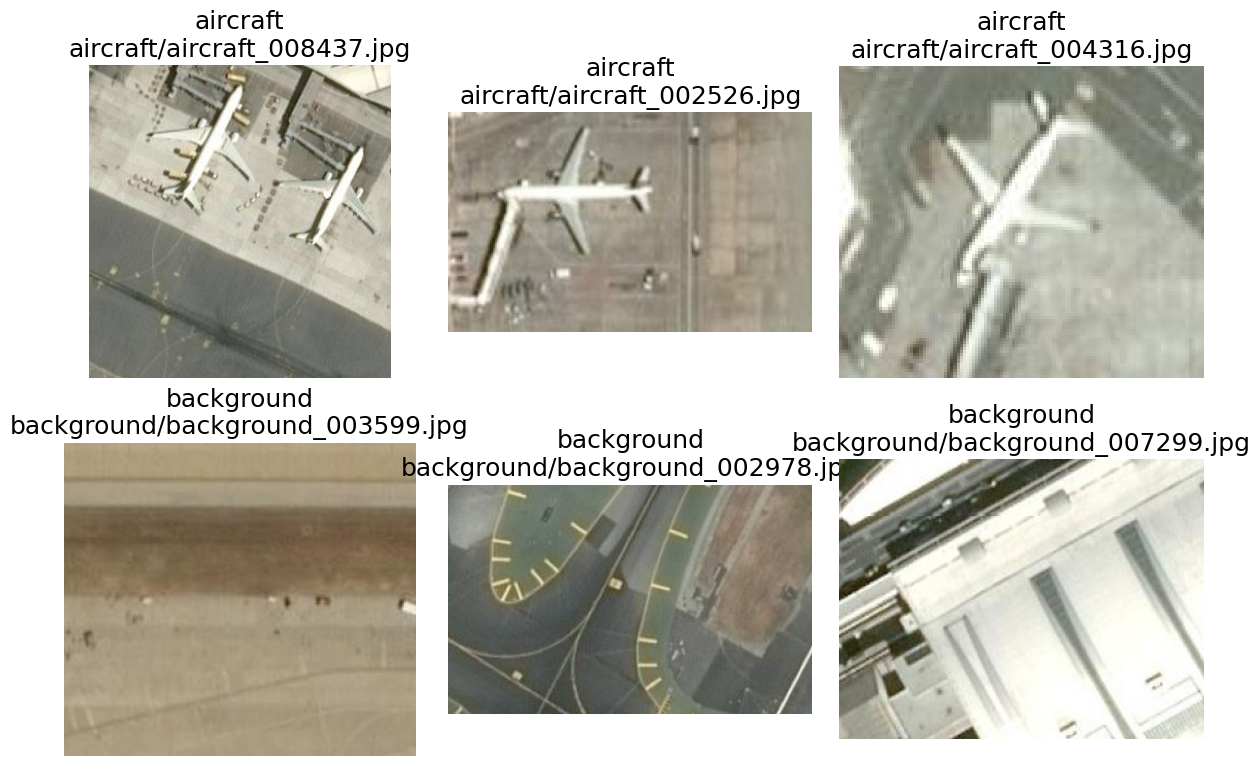

In [6]:
def show_random_samples(per_class: int = 3) -> None:
    fig, axes = plt.subplots(2, per_class, figsize=(4 * per_class, 8))
    axes = np.atleast_2d(axes)

    for row_idx, label in enumerate([1, 0]):
        subset = metadata_df[metadata_df["label"] == label]
        picks = subset.sample(n=min(per_class, len(subset)), random_state=SEED + row_idx)
        for col_idx, (_, row) in enumerate(picks.iterrows()):
            ax = axes[row_idx, col_idx]
            with Image.open(BASE_DIR / row["image_path"]) as img:
                img_arr = np.array(img)
            ax.imshow(img_arr)
            cls_name = "aircraft" if label == 1 else "background"
            ax.set_title(f"{cls_name}\n{row['image_path']}")
            ax.axis("off")

    plt.tight_layout()


show_random_samples()



## Train / validation split (80/20 stratified)


In [7]:
train_df, val_df = train_test_split(
    metadata_df,
    test_size=0.2,
    random_state=SEED,
    stratify=metadata_df["label"],
)

train_df = train_df.reset_index(drop=True)
val_df = val_df.reset_index(drop=True)

print(f"Training samples: {len(train_df):,}")
print(f"Validation samples: {len(val_df):,}")


Training samples: 16,000
Validation samples: 4,000


## Dataset and dataloaders


In [ ]:
class AirbusClassificationDataset(Dataset):
    def __init__(self, df: pd.DataFrame, root_dir: Path, transform: transforms.Compose) -> None:
        self.df = df.reset_index(drop=True)
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self) -> int:
        return len(self.df)

    def __getitem__(self, idx: int) -> Dict[str, torch.Tensor]:
        row = self.df.iloc[idx]
        img_path = self.root_dir / row["image_path"]
        with Image.open(img_path) as img:
            img = img.convert("RGB")
            img = self.transform(img)
        label = torch.tensor(int(row["label"]), dtype=torch.long)
        return {"image": img, "label": label}


def build_transforms(image_size: int = 224) -> Dict[str, transforms.Compose]:
    train_tfms = transforms.Compose(
        [
            transforms.RandomResizedCrop(image_size, scale=(0.7, 1.0)),
            transforms.RandomHorizontalFlip(),
            transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
            transforms.ToTensor(),
            transforms.Normalize(IMAGENET_MEAN, IMAGENET_STD),
        ]
    )

    val_tfms = transforms.Compose(
        [
            transforms.Resize(int(image_size * 1.15)),
            transforms.CenterCrop(image_size),
            transforms.ToTensor(),
            transforms.Normalize(IMAGENET_MEAN, IMAGENET_STD),
        ]
    )
    return {"train": train_tfms, "val": val_tfms}


def create_dataloaders(
    batch_size: int,
    num_workers: int = 4,
    image_size: int = 224,
    train_table: pd.DataFrame | None = None,
    val_table: pd.DataFrame | None = None,
):
    tfms = build_transforms(image_size=image_size)
    train_table = train_table if train_table is not None else train_df
    val_table = val_table if val_table is not None else val_df

    train_dataset = AirbusClassificationDataset(train_table, BASE_DIR, tfms["train"])
    val_dataset = AirbusClassificationDataset(val_table, BASE_DIR, tfms["val"])

    worker_kwargs = {}
    if num_workers > 0:
        worker_kwargs.update({"prefetch_factor": 4, "persistent_workers": True})

    train_loader = DataLoader(
        train_dataset,
        batch_size=batch_size,
        shuffle=True,
        num_workers=num_workers,
        pin_memory=True,
        **worker_kwargs,
    )
    val_loader = DataLoader(
        val_dataset,
        batch_size=batch_size,
        shuffle=False,
        num_workers=num_workers,
        pin_memory=True,
        **worker_kwargs,
    )
    return train_loader, val_loader



## Training utilities


In [9]:
def accuracy_from_logits(logits: torch.Tensor, labels: torch.Tensor) -> float:
    preds = logits.argmax(dim=1)
    return (preds == labels).float().mean().item()


def run_epoch(model, loader, criterion, optimizer=None):
    is_train = optimizer is not None
    model.train(mode=is_train)
    total_loss = 0.0
    total_correct = 0.0
    total_samples = 0

    for batch in loader:
        images = batch["image"].to(DEVICE, non_blocking=True)
        labels = batch["label"].to(DEVICE, non_blocking=True)

        with torch.set_grad_enabled(is_train):
            logits = model(images)
            loss = criterion(logits, labels)

        if is_train:
            optimizer.zero_grad(set_to_none=True)
            loss.backward()
            optimizer.step()

        batch_size = images.size(0)
        total_loss += loss.item() * batch_size
        total_correct += (logits.argmax(dim=1) == labels).sum().item()
        total_samples += batch_size

    avg_loss = total_loss / total_samples
    avg_acc = total_correct / total_samples
    return avg_loss, avg_acc


def train_model(
    model: nn.Module,
    train_loader: DataLoader,
    val_loader: DataLoader,
    optimizer: torch.optim.Optimizer,
    scheduler: torch.optim.lr_scheduler._LRScheduler | None,
    epochs: int,
) -> List[Dict[str, float]]:
    criterion = nn.CrossEntropyLoss()
    history = []
    best_val_acc = 0.0
    best_state = None

    for epoch in range(1, epochs + 1):
        train_loss, train_acc = run_epoch(model, train_loader, criterion, optimizer)
        val_loss, val_acc = run_epoch(model, val_loader, criterion, optimizer=None)

        if scheduler is not None:
            scheduler.step()

        history.append(
            {
                "epoch": epoch,
                "train_loss": train_loss,
                "train_acc": train_acc,
                "val_loss": val_loss,
                "val_acc": val_acc,
                "lr": optimizer.param_groups[0]["lr"],
            }
        )

        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_state = {
                "epoch": epoch,
                "model": model.state_dict(),
                "optimizer": optimizer.state_dict(),
            }

        print(
            f"Epoch {epoch:02d}/{epochs} | "
            f"train_loss={train_loss:.4f}, train_acc={train_acc:.3f} | "
            f"val_loss={val_loss:.4f}, val_acc={val_acc:.3f}"
        )

    if best_state:
        model.load_state_dict(best_state["model"])

    return history



### Speeding up Optuna
Hyper-parameter search now limits each trial to balanced subsets (configurable via `OPTUNA_MAX_*` constants) and enables persistent dataloader workers to avoid repeatedly respawning Python processes on Windows. This keeps GPU utilization high and lets the Optuna progress bar move immediately after each shorter trial.


## Hyperparameter search with Optuna


In [ ]:
OPTUNA_TRIALS = 10
OPTUNA_EPOCHS = 5
OPTUNA_MAX_TRAIN_SAMPLES_PER_CLASS = 2000  # use smaller stratified subset per trial for speed
OPTUNA_MAX_VAL_SAMPLES_PER_CLASS = 500
NUM_WORKERS = max(2, (os.cpu_count() or 4) // 2)

trial_summaries = []


def stratified_subset(df: pd.DataFrame, max_per_class: int | None, seed: int) -> pd.DataFrame:
    if max_per_class is None:
        return df
    sampled = (
        df.groupby("label", group_keys=False)
        .apply(lambda grp: grp.sample(n=min(len(grp), max_per_class), random_state=seed))
        .reset_index(drop=True)
    )
    return sampled


def objective(trial: optuna.Trial) -> float:
    dropout = trial.suggest_float("dropout", 0.3, 0.6)
    lr = trial.suggest_float("lr", 1e-4, 5e-3, log=True)
    weight_decay = trial.suggest_float("weight_decay", 1e-6, 1e-3, log=True)
    batch_size = trial.suggest_categorical("batch_size", [32, 48, 64, 96])
    image_size = trial.suggest_categorical("image_size", [224, 256])

    subset_seed = SEED + trial.number
    train_subset = stratified_subset(train_df, OPTUNA_MAX_TRAIN_SAMPLES_PER_CLASS, seed=subset_seed)
    val_subset = stratified_subset(val_df, OPTUNA_MAX_VAL_SAMPLES_PER_CLASS, seed=subset_seed)

    train_loader, val_loader = create_dataloaders(
        batch_size=batch_size,
        num_workers=NUM_WORKERS,
        image_size=image_size,
        train_table=train_subset,
        val_table=val_subset,
    )

    model = build_alexnet_classifier(num_classes=2, dropout=dropout).to(DEVICE)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=OPTUNA_EPOCHS)
    criterion = nn.CrossEntropyLoss()

    best_val_acc = 0.0
    for epoch in range(OPTUNA_EPOCHS):
        train_loss, train_acc = run_epoch(model, train_loader, criterion, optimizer)
        val_loss, val_acc = run_epoch(model, val_loader, criterion)
        scheduler.step()

        trial.report(val_acc, step=epoch)
        if trial.should_prune():
            raise optuna.TrialPruned()

        if val_acc > best_val_acc:
            best_val_acc = val_acc

    trial.set_user_attr("best_val_acc", best_val_acc)
    trial_summaries.append(
        {
            "trial": trial.number,
            "best_val_acc": best_val_acc,
            "params": trial.params.copy(),
            "train_samples": len(train_subset),
            "val_samples": len(val_subset),
        }
    )
    return best_val_acc


study = optuna.create_study(direction="maximize", pruner=optuna.pruners.MedianPruner(n_startup_trials=2))
study.optimize(objective, n_trials=OPTUNA_TRIALS, show_progress_bar=True)
print("Best trial:", study.best_trial.number)
print("Best value:", study.best_value)
print("Best params:", study.best_params)



[I 2025-11-27 22:33:05,379] A new study created in memory with name: no-name-5fdfc3ff-9d79-4503-8cd4-821938885ead


  0%|          | 0/10 [00:00<?, ?it/s]

### Optuna summary


In [ ]:
trial_summary_df = pd.DataFrame(trial_summaries)
trial_summary_df.sort_values("best_val_acc", ascending=False).head()


## Final training run with best hyperparameters


In [ ]:
BEST_PARAMS = study.best_params
FINAL_EPOCHS = 20

train_loader, val_loader = create_dataloaders(
    batch_size=BEST_PARAMS.get("batch_size", 64),
    num_workers=NUM_WORKERS,
    image_size=BEST_PARAMS.get("image_size", 224),
)

model = build_alexnet_classifier(
    num_classes=2,
    dropout=BEST_PARAMS.get("dropout", 0.5),
).to(DEVICE)

optimizer = torch.optim.Adam(
    model.parameters(),
    lr=BEST_PARAMS.get("lr", 1e-3),
    weight_decay=BEST_PARAMS.get("weight_decay", 1e-4),
)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=FINAL_EPOCHS)

history = train_model(
    model,
    train_loader,
    val_loader,
    optimizer,
    scheduler,
    epochs=FINAL_EPOCHS,
)

history_df = pd.DataFrame(history)
history_df


## Plot loss and accuracy history


In [ ]:
def plot_history(df: pd.DataFrame) -> None:
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))

    axes[0].plot(df["epoch"], df["train_loss"], label="train")
    axes[0].plot(df["epoch"], df["val_loss"], label="val")
    axes[0].set_title("Loss")
    axes[0].set_xlabel("Epoch")
    axes[0].set_ylabel("Cross-entropy")
    axes[0].legend()

    axes[1].plot(df["epoch"], df["train_acc"], label="train")
    axes[1].plot(df["epoch"], df["val_acc"], label="val")
    axes[1].set_title("Accuracy")
    axes[1].set_xlabel("Epoch")
    axes[1].set_ylabel("Accuracy")
    axes[1].legend()

    plt.tight_layout()


plot_history(history_df)



## Validation evaluation


In [ ]:
model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for batch in val_loader:
        images = batch["image"].to(DEVICE, non_blocking=True)
        labels = batch["label"].to(DEVICE, non_blocking=True)
        logits = model(images)
        preds = logits.argmax(dim=1)
        all_preds.append(preds.cpu())
        all_labels.append(labels.cpu())

all_preds = torch.cat(all_preds).numpy()
all_labels = torch.cat(all_labels).numpy()

val_acc = (all_preds == all_labels).mean()
print(f"Validation accuracy: {val_acc:.4f}")
print(classification_report(all_labels, all_preds, target_names=["background", "aircraft"]))
print("Confusion matrix:\n", confusion_matrix(all_labels, all_preds))


## Save classifier weights


In [ ]:
torch.save(model.state_dict(), MODEL_WEIGHTS_PATH)
print(f"Saved classifier weights to {MODEL_WEIGHTS_PATH}")


---
With the trained weights stored under `artifacts/alexnet_classifier_weights.pth`, you can now load them to initialize the detector’s backbone for improved convergence.
